In [8]:
import numpy as np
import pylab as plt
#from numpy import fft
import healpy as hp
from astropy.cosmology import Planck15, default_cosmology
from astropy import constants as const
from astropy import units as un
from astropy.coordinates import SkyCoord
import h5py
from scipy import signal
from astropy.io import ascii, fits

fft = np.fft.fft
fft2 = np.fft.fft2
ifft2 = np.fft.ifft2
fftshift = np.fft.fftshift
ifftshift = np.fft.ifftshift

## Defining the cosmology - Planck15 of astropy 
cosmo = Planck15
f21 = 1420.405752 * un.MHz # MHz
c = const.c.value # m/s
print('The 21 cm line emission freq - ',f21)

The 21 cm line emission freq -  1420.405752 MHz


In [9]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
%matplotlib inline

plt.rc('font', family='serif', weight='normal', size=22.0)
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')

import copy
COLORMAP = copy.copy(matplotlib.cm.__dict__["inferno"])
COLORMAP.set_under("black")
COLORMAP.set_bad("lightgray")

In [10]:
import os
import copy


In [11]:
datapath = '/project/def-mdobbs/arnab92/SKAD3/data/chan_0-149_image'

In [12]:
data_1 = os.path.join(datapath,'out_name-0000-image.fits')

In [13]:
hdu = fits.open(data_1)[0]

In [14]:
hdr = hdu.header

In [15]:
hdr

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    4 / number of data axes                            
NAXIS1  =                 2048 / length of data axis 1                          
NAXIS2  =                 2048 / length of data axis 2                          
NAXIS3  =                    1 / length of data axis 3                          
NAXIS4  =                    1 / length of data axis 4                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BSCALE  =                   1.                                                  
BZERO   =                   0.                                                  
BUNIT   = 'JY/BEAM '        

In [16]:
image = np.array(hdu.data[:])

In [17]:
image.shape

(1, 1, 2048, 2048)

In [18]:
_,_, Nx, Ny = image.shape

In [19]:
# Freq array of the data
freq0 = hdr.get('CRVAL3') # First freq channel value in Hz
chan_res = hdr.get('CDELT3') # chan res in Hz

In [20]:
freq0/1e6, chan_res/1e6

(106.0, 0.1)

In [21]:
DEC_c = hdr.get('CRVAL2')
RA_c = hdr.get('CRVAL1')
cdelta2 = hdr.get('CDELT2')
cdelta1 = hdr.get('CDELT1')
DEC = np.arange((DEC_c-(cdelta2*Ny/2.)) , (DEC_c+(cdelta2*Ny/2.)), cdelta2)
RA = np.arange((RA_c-(cdelta1*Nx/2.)) , (RA_c+(cdelta1*Nx/2.)), cdelta1)

print(f'RA size: {RA.size} and DEC size {DEC.size}')

print(f"RA range : {RA[0]} to {RA[-1]}")
print(f"DEC range : {DEC[0]} to {DEC[-1]}")

RA size: 2048 and DEC size 2048
RA range : 4.551111111111107 to -4.546666666666274
DEC range : -4.551111111111107 to 4.546666666666274


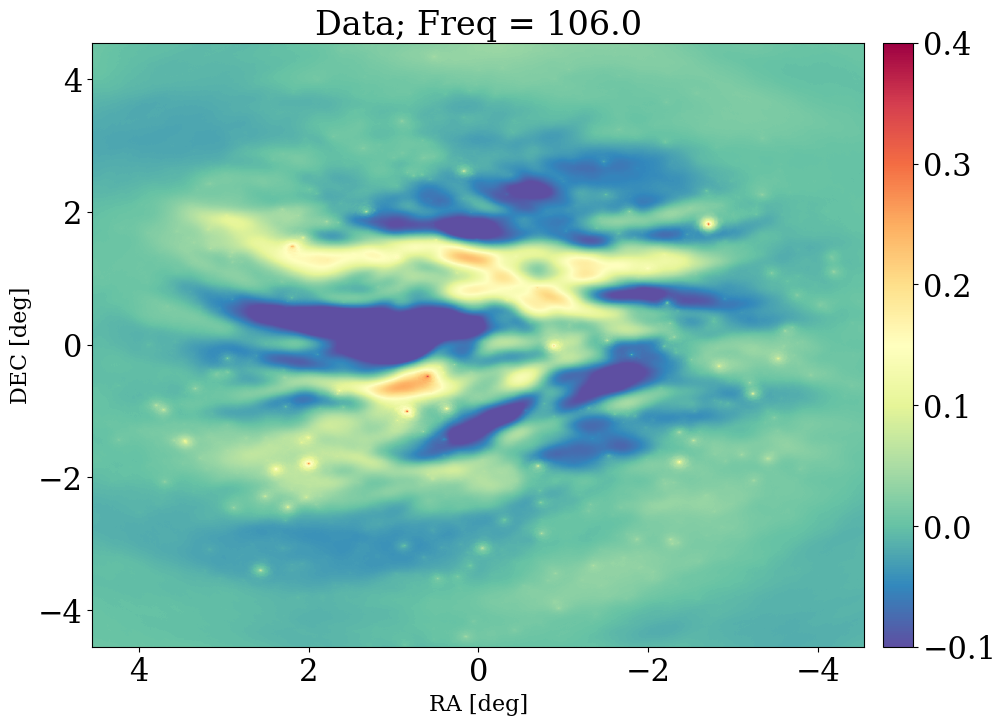

In [22]:
ext=(RA[0],RA[-1], DEC[0], DEC[-1])
imshow_kwargs = dict(aspect='auto', origin='lower', interpolation='nearest', 
                     extent=ext,vmin=-0.1,vmax=0.4, cmap='Spectral_r')
plt.figure(figsize=(12,8),dpi=100)
nu_id = 0
im = plt.imshow(image[0,0,:,:],**imshow_kwargs)
plt.xlabel("RA [deg]",fontsize=16)
plt.ylabel('DEC [deg]',fontsize=16)
plt.title(f'Data; Freq = {freq0/1e6}',fontsize=24)
plt.colorbar(orientation='vertical',pad=0.02)

In [31]:
import os
import sys
import re
import argparse
from datetime import datetime, timezone
from functools import lru_cache

import numpy as np
from astropy.io import fits
from astropy.wcs import WCS


class FITSCube:
    """
    FITS image cube.
    """
    def __init__(self, infile=None):
        if infile is not None:
            self.load(infile)

    def load(self, infile):
        with fits.open(infile) as f:
            self.data = f[0].data
            self.header = f[0].header
        print("Loaded FITS cube from file: %s" % infile)
        print("Cube dimensions: %dx%dx%d" %
              (self.width, self.height, self.nslice))
        # The Z-axis position of the first slice.
        self.zbegin = self.header["CRVAL3"]
        # The Z-axis step/spacing between slices.
        self.zstep = self.header["CDELT3"]

    def add_slices(self, infiles, zbegin=0.0, zstep=1.0):
        """
        Create a FITS cube from input image slices.

        NOTE: The infiles should be sorted appropriately.
        """
        self.infiles = infiles
        self.zbegin = zbegin
        self.zstep = zstep
        N = len(infiles)
        zvalues = zbegin + zstep * np.arange(N)
        header, image = self.open_image(infiles[0])
        height, width = image.shape
        data = np.zeros((N, height, width), dtype=image.dtype)
        for i, (z, fn) in enumerate(zip(zvalues, infiles)):
            print("[%2d/%2d] slice @ %s: %s ..." % (i+1, N, z, fn))
            hdr, img = self.open_image(fn)
            data[i, :, :] = img
        self.data = data
        self.header = header.copy(strip=True)
        print("Cube dimension: %dx%dx%d" % (width, height, N))

    @staticmethod
    def open_image(infile):
        """
        Open the slice image and return its header and 2D image data.

        NOTE
        ----
        The input slice image may have following dimensions:
        * NAXIS=2: [Y, X]
        * NAXIS=3: [FREQ=1, Y, X]
        * NAXIS=4: [STOKES=1, FREQ=1, Y, X]

        NOTE
        ----
        Only open slice image that has only ONE frequency and ONE Stokes
        parameter.

        Returns
        -------
        header : `~astropy.io.fits.Header`
        image : 2D `~numpy.ndarray`
            The 2D [Y, X] image part of the slice image.
        """
        with fits.open(infile) as f:
            header = f[0].header
            data = f[0].data
        if data.ndim == 2:
            # NAXIS=2: [Y, X]
            image = data
        elif data.ndim == 3 and data.shape[0] == 1:
            # NAXIS=3: [FREQ=1, Y, X]
            image = data[0, :, :]
        elif data.ndim == 4 and data.shape[0] == 1 and data.shape[1] == 1:
            # NAXIS=4: [STOKES=1, FREQ=1, Y, X]
            image = data[0, 0, :, :]
        else:
            raise ValueError("Slice '{0}' has invalid dimensions: {1}".format(
                infile, data.shape))
        return (header, image)

    @property
    def header(self):
        if not hasattr(self, "header_"):
            self.header_ = fits.Header()
        return self.header_

    @header.setter
    def header(self, value):
        self.header_ = value
        for key in ["CTYPE4", "CRPIX4", "CRVAL4", "CDELT4", "CUNIT4"]:
            try:
                del self.header_[key]
            except KeyError:
                pass

    @property
    @lru_cache()
    def wcs(self):
        w = WCS(naxis=3)
        w.wcs.ctype = ["pixel", "pixel", "pixel"]
        w.wcs.crpix = np.array([self.header.get("CRPIX1", 1.0),
                                self.header.get("CRPIX2", 1.0),
                                1.0])
        w.wcs.crval = np.array([self.header.get("CRVAL1", 0.0),
                                self.header.get("CRVAL2", 0.0),
                                self.zbegin])
        w.wcs.cdelt = np.array([self.header.get("CDELT1", 1.0),
                                self.header.get("CDELT2", 1.0),
                                self.zstep])
        return w

    def keyword(self, key, value=None, comment=None):
        header = self.header
        if value is None:
            return header[key]
        else:
            header[key] = (value, comment)

    def write(self, outfile, clobber=False):
        header = self.header
        header.extend(self.wcs.to_header(), update=True)
        header["DATE"] = (datetime.now(timezone.utc).astimezone().isoformat(),
                          "File creation date")
        header.add_history(" ".join(sys.argv))
        hdu = fits.PrimaryHDU(data=self.data, header=header)
        try:
            hdu.writeto(outfile, overwrite=clobber)
        except TypeError:
            hdu.writeto(outfile, clobber=clobber)

    @property
    def width(self):
        __, __, w = self.data.shape
        return w

    @property
    def height(self):
        __, h, __ = self.data.shape
        return h

    @property
    def nslice(self):
        ns, __, __ = self.data.shape
        return ns

    @property
    @lru_cache()
    def zvalues(self):
        """
        Calculate the Z-axis positions for all slices
        """
        nslice = self.nslice
        wcs = self.wcs
        pix = np.zeros(shape=(nslice, 3), dtype=int)
        pix[:, 2] = np.arange(nslice)
        world = wcs.wcs_pix2world(pix, 0)
        return world[:, 2]

    @property
    def slices(self):
        """
        A list of slices in the cube w.r.t. ``zvalues``.
        """
        return (self.data[i, :, :] for i in range(self.nslice))

    def get_slice(self, i, csize=None):
        """
        Get the i-th (0-based) slice image, and crop out the central box
        of size ``csize`` if specified.
        """
        if csize is None:
            return self.data[i, :, :]
        else:
            rows, cols = self.height, self.width
            rc, cc = rows//2, cols//2
            cs1, cs2 = csize//2, (csize+1)//2
            return self.data[i, (rc-cs1):(rc+cs2), (cc-cs1):(cc+cs2)]

    def apply_gain(self, gain):
        """
        Multiply the supplied ``gain`` to each slice, to achieve slice
        or channel response calibration or corruption.
        """
        gain = np.asarray(gain)
        self.data *= gain[:, np.newaxis, np.newaxis]

    def pool(self, blocksize, func=np.mean):
        """
        Down-sampling the images by pooling
        """
        try:
            from skimage.measure import block_reduce
        except ImportError:
            print("scikit-image not installed")
            raise

        self.data = block_reduce(self.data,
                                 block_size=(1, blocksize, blocksize),
                                 func=func)
        self.keyword(key="POOL_BS", value=blocksize,
                     comment="down-sampling block size")
        self.keyword(key="POOL_FUN", value=func.__name__,
                     comment="down-sampling function/method")

    @property
    def unit(self):
        """
        Cube data unit.
        """
        return self.header.get("BUNIT")

    @unit.setter
    def unit(self, value):
        self.header["BUNIT"] = value

    @property
    def zunit(self):
        """
        Unit of the slice z-axis positions.
        """
        return self.header.get("CUNIT3")

    @zunit.setter
    def zunit(self, value):
        self.header["CUNIT3"] = value

In [32]:
def cmd_create(args):
    """
    Sub-command: "create", create a FITS cube
    """
    def sorted_natural(l):
        # Credit: https://stackoverflow.com/a/4623518

        def _tryint(s):
            try:
                return int(s)
            except ValueError:
                return s

        def _alphanum_key(s):
            return [_tryint(c) for c in re.split(r'([0-9]+)', s)]

        return sorted(l, key=_alphanum_key)

    if not args.clobber and os.path.exists(args.outfile):
        raise FileExistsError("output file already exists: %s" % args.outfile)

    if args.sort:
        infiles = sorted_natural(args.infiles)
    else:
        infiles = args.infiles

    N = len(infiles)
    print("Input slices:")
    for i, fn in enumerate(infiles):
        print("  + [%2d/%2d] %s" % (i+1, N, fn))

    cube = FITSCube()
    print("Adding slices to cube ...")
    cube.add_slices(infiles, zbegin=args.zbegin, zstep=args.zstep)
    cube.zunit = args.zunit
    if args.unit:
        cube.unit = args.unit

    cube.write(args.outfile, clobber=args.clobber)
    print("Created FITS cube: %s" % args.outfile)

In [24]:
from os import listdir
from os.path import isfile, join
onlyfiles = [datapath+'/'+f for f in listdir(datapath)]

In [28]:
onlyfiles

['/project/def-mdobbs/arnab92/SKAD3/data/chan_0-149_image/out_name-0111-image.fits',
 '/project/def-mdobbs/arnab92/SKAD3/data/chan_0-149_image/out_name-0091-image.fits',
 '/project/def-mdobbs/arnab92/SKAD3/data/chan_0-149_image/out_name-0031-image.fits',
 '/project/def-mdobbs/arnab92/SKAD3/data/chan_0-149_image/out_name-0139-image.fits',
 '/project/def-mdobbs/arnab92/SKAD3/data/chan_0-149_image/out_name-0060-image.fits',
 '/project/def-mdobbs/arnab92/SKAD3/data/chan_0-149_image/out_name-0082-image.fits',
 '/project/def-mdobbs/arnab92/SKAD3/data/chan_0-149_image/out_name-0110-image.fits',
 '/project/def-mdobbs/arnab92/SKAD3/data/chan_0-149_image/out_name-0001-image.fits',
 '/project/def-mdobbs/arnab92/SKAD3/data/chan_0-149_image/out_name-0015-image.fits',
 '/project/def-mdobbs/arnab92/SKAD3/data/chan_0-149_image/out_name-0040-image.fits',
 '/project/def-mdobbs/arnab92/SKAD3/data/chan_0-149_image/out_name-0088-image.fits',
 '/project/def-mdobbs/arnab92/SKAD3/data/chan_0-149_image/out_nam

In [33]:
def sorted_natural(l):
        # Credit: https://stackoverflow.com/a/4623518

        def _tryint(s):
            try:
                return int(s)
            except ValueError:
                return s

        def _alphanum_key(s):
            return [_tryint(c) for c in re.split(r'([0-9]+)', s)]

        return sorted(l, key=_alphanum_key)

In [34]:
infiles = sorted_natural(onlyfiles)

In [35]:
N = len(infiles)
print("Input slices:")
for i, fn in enumerate(infiles):
    print("  + [%2d/%2d] %s" % (i+1, N, fn))

Input slices:
  + [ 1/150] /project/def-mdobbs/arnab92/SKAD3/data/chan_0-149_image/out_name-0000-image.fits
  + [ 2/150] /project/def-mdobbs/arnab92/SKAD3/data/chan_0-149_image/out_name-0001-image.fits
  + [ 3/150] /project/def-mdobbs/arnab92/SKAD3/data/chan_0-149_image/out_name-0002-image.fits
  + [ 4/150] /project/def-mdobbs/arnab92/SKAD3/data/chan_0-149_image/out_name-0003-image.fits
  + [ 5/150] /project/def-mdobbs/arnab92/SKAD3/data/chan_0-149_image/out_name-0004-image.fits
  + [ 6/150] /project/def-mdobbs/arnab92/SKAD3/data/chan_0-149_image/out_name-0005-image.fits
  + [ 7/150] /project/def-mdobbs/arnab92/SKAD3/data/chan_0-149_image/out_name-0006-image.fits
  + [ 8/150] /project/def-mdobbs/arnab92/SKAD3/data/chan_0-149_image/out_name-0007-image.fits
  + [ 9/150] /project/def-mdobbs/arnab92/SKAD3/data/chan_0-149_image/out_name-0008-image.fits
  + [10/150] /project/def-mdobbs/arnab92/SKAD3/data/chan_0-149_image/out_name-0009-image.fits
  + [11/150] /project/def-mdobbs/arnab92/SKAD3

In [37]:
cube = FITSCube()

In [38]:
print("Adding slices to cube ...")
cube.add_slices(infiles,zbegin=106e6,zstep=0.1e6)

Adding slices to cube ...
[ 1/150] slice @ 106000000.0: /project/def-mdobbs/arnab92/SKAD3/data/chan_0-149_image/out_name-0000-image.fits ...
[ 2/150] slice @ 106100000.0: /project/def-mdobbs/arnab92/SKAD3/data/chan_0-149_image/out_name-0001-image.fits ...
[ 3/150] slice @ 106200000.0: /project/def-mdobbs/arnab92/SKAD3/data/chan_0-149_image/out_name-0002-image.fits ...
[ 4/150] slice @ 106300000.0: /project/def-mdobbs/arnab92/SKAD3/data/chan_0-149_image/out_name-0003-image.fits ...
[ 5/150] slice @ 106400000.0: /project/def-mdobbs/arnab92/SKAD3/data/chan_0-149_image/out_name-0004-image.fits ...
[ 6/150] slice @ 106500000.0: /project/def-mdobbs/arnab92/SKAD3/data/chan_0-149_image/out_name-0005-image.fits ...
[ 7/150] slice @ 106600000.0: /project/def-mdobbs/arnab92/SKAD3/data/chan_0-149_image/out_name-0006-image.fits ...
[ 8/150] slice @ 106700000.0: /project/def-mdobbs/arnab92/SKAD3/data/chan_0-149_image/out_name-0007-image.fits ...
[ 9/150] slice @ 106800000.0: /project/def-mdobbs/arna

In [39]:
cube.header

COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BUNIT   = 'JY/BEAM '           / Units are in Jansky per beam                   
BMAJ    =   0.0553606459998762                                                  
BMIN    =   0.0411476603439643                                                  
BPA     =     131.557841366125                                                  
EQUINOX =                2000. / J2000                                          
BTYPE   = 'Intensity'                                                           
ORIGIN  = 'WSClean '           / W-stacking imager written by Andre Offringa    
CTYPE1  = 'RA---SIN'           / Right ascension angle cosine                   
CRPIX1  =                1025.                                                  
CRVAL1  =                   0.                                                  
CDELT1  = -0.004444444444444

In [40]:
z_unit = 'Hz'

In [41]:
cube.zunit = z_unit

In [42]:
outfile = datapath+'/combined_cube.fits'

In [43]:
outfile

'/project/def-mdobbs/arnab92/SKAD3/data/chan_0-149_image/combined_cube.fits'

In [44]:
cube.write(outfile, clobber=True)

In [45]:
data_c = os.path.join(datapath,'combined_cube.fits')

In [6]:
hdu = fits.open(data_c)[0]

In [7]:
hdu.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 2048                                                  
NAXIS3  =                  150                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BUNIT   = 'JY/BEAM '           / Units are in Jansky per beam                   
BMAJ    =   0.0553606459998762                                                  
BMIN    =   0.0411476603439643                                                  
BPA     =     131.557841366125                                                  
EQUINOX =                200

In [132]:
image = np.array(hdu.data[:])

In [133]:
image.shape

(150, 2048, 2048)

In [134]:
nfreq, Nx, Ny = image.shape

In [135]:
# Freq array of the data
freq0 = hdr.get('CRVAL3') # First freq channel value in Hz
chan_res = hdr.get('CDELT3') # chan res in Hz
freq = freq0 + chan_res * (np.arange(nfreq)) # The freq array in Hz
print(f"freq range : {freq[0]/1e6} to {freq[-1]/1e6} MHz")
print(f" Chan res : {chan_res} MHz")

freq range : 106.0 to 120.9 MHz
 Chan res : 100000.0 MHz


In [136]:
freq0

106000000.0

In [137]:
# Resolution of the image
dx = hdr.get('CDELT1') # pixel size in X-direction, in deg
dy = hdr.get('CDELT2') # pixel size in Y-direction , in deg
print(f'pixel size in X and Y directions are, dx:{abs(dx*3600)} arcsec and dy:{abs(dy*3600)} arcsec')

pixel size in X and Y directions are, dx:15.999999999999984 arcsec and dy:15.999999999999984 arcsec


In [138]:
DEC_c = hdr.get('CRVAL2')
RA_c = hdr.get('CRVAL1')
cdelta2 = hdr.get('CDELT2')
cdelta1 = hdr.get('CDELT1')
DEC = np.arange((DEC_c-(cdelta2*Ny/2.)) , (DEC_c+(cdelta2*Ny/2.)), cdelta2)
RA = np.arange((RA_c-(cdelta1*Nx/2.)) , (RA_c+(cdelta1*Nx/2.)), cdelta1)

print(f'RA size: {RA.size} and DEC size {DEC.size}')

print(f"RA range : {RA[0]} to {RA[-1]}")
print(f"DEC range : {DEC[0]} to {DEC[-1]}")

RA size: 2048 and DEC size 2048
RA range : 4.551111111111107 to -4.546666666666274
DEC range : -4.551111111111107 to 4.546666666666274


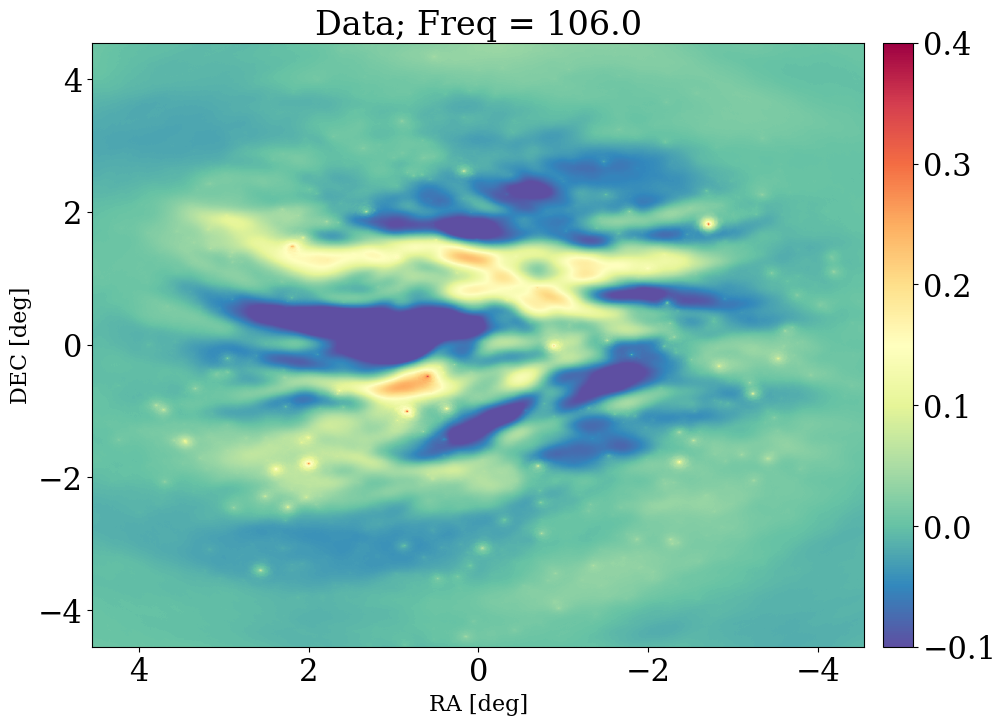

In [139]:
ext=(RA[0],RA[-1], DEC[0], DEC[-1])
imshow_kwargs = dict(aspect='auto', origin='lower', interpolation='nearest', 
                     extent=ext,vmin=-0.1,vmax=0.4, cmap='Spectral_r')
plt.figure(figsize=(12,8),dpi=100)
nu_id = 0
im = plt.imshow(image[nu_id,:,:],**imshow_kwargs)
plt.xlabel("RA [deg]",fontsize=16)
plt.ylabel('DEC [deg]',fontsize=16)
plt.title(f'Data; Freq = {freq[nu_id]/1e6}',fontsize=24)
plt.colorbar(orientation='vertical',pad=0.02)